In [37]:
import matplotlib.pyplot as plt
import random
import math
from itertools import permutations
import numpy as np

In [38]:
class City:
    ''' 
    This class represents a City as a dot on the map with x,y coordinates and a name to identify the city.
    '''

    def __init__(self, x, y, name) -> None:
        self.x = x
        self.y  = y
        self.name = name

    def coordinates(self):
        return self.x, self.y


class TSPmap:
    '''
    This class contains a dictionary of the cities, accesable thought the city names and also
    helper functions to compute metrics, generate routes and plot routes and cities.
    '''
    cities = {}

    '''coordinates'''
    def cities_x(self):
        return list(map(lambda c: c.x, list(self.cities.values())))
    
    def cities_y(self):
        return list(map(lambda c: c.y, list(self.cities.values())))
    
    '''distance'''
    def city_distance(self, city1, city2):
        if type(city1) != City and type(city2) != City:
            c1 = self.cities[city1]
            c2 = self.cities[city2]
            return math.sqrt((c1.x - c2.x)**2 + (c1.y - c2.y)**2)
        return math.sqrt((city1.x - city2.x)**2 + (city1.y - city2.y)**2)
    
    def route_distance(self, route):
        distance = 0
        for name1, name2 in zip(route, np.append(route[1:],[route[0]])):
                distance += self.city_distance(self.cities[name1], self.cities[name2])
        return distance

    '''routes'''
    def generate_route(self):
        route = list(range(len(self.cities)))
        random.shuffle(route)
        return route
    
    def generate_routes(self, N):
        shuffles = []
        names = list(range(len(self.cities.values())))
        for _ in range(N):
            random.shuffle(names)
            shuffles.append(names.copy())
        return shuffles
    
    def route_fitness(self, route):
        return 1 / float(self.route_distance(route))

    '''plotting'''
    def plot_map(self):
        fig = plt.figure()
        plt.scatter(self.cities_x(), self.cities_y())
        plt.show()

    def plot_route(self, route):
        for name1, name2 in zip(route, np.append(route[1:], [route[0]])):
            x1, y1 = self.cities[name1].coordinates()
            x2, y2 = self.cities[name2].coordinates()
            plt.plot([x1, x2], [y1, y2], 'blue')

    def predef_plot_route(self, predef_plot, route):
        for name1, name2 in zip(route, np.append(route[1:], [route[0]])):
            x1, y1 = self.cities[name1].coordinates()
            x2, y2 = self.cities[name2].coordinates()
            predef_plot.plot([x1, x2], [y1, y2], 'blue')
            

    


In [39]:
tsp_map = TSPmap()

# read the file-tsp and serialize into the TSP map and City classes
with open('file-tsp.txt') as f:
    name = 0
    for line in f:
        line = line.strip()
        x = float(line[:7])
        y = float(line[7:].strip())
        tsp_map.cities[name] = City(x, y, str(name))
        name +=1


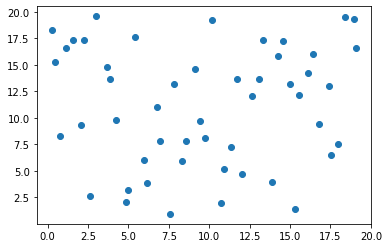

In [40]:
# plot the map, every dot is a city
tsp_map.plot_map()

In [41]:
# example of a generated route
route = tsp_map.generate_route()
print(route)

[21, 1, 32, 43, 15, 45, 11, 27, 46, 49, 9, 3, 6, 48, 41, 37, 36, 17, 22, 24, 38, 8, 26, 0, 4, 5, 12, 42, 19, 44, 34, 40, 31, 7, 10, 39, 33, 28, 18, 35, 13, 47, 29, 14, 23, 30, 16, 20, 25, 2]


0.002169057087296401

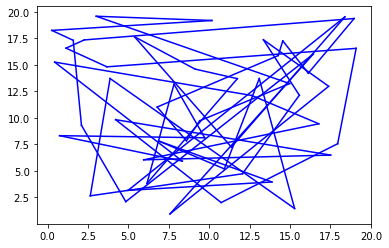

In [42]:
# plot the generated route and print its fitness
tsp_map.plot_route(route)
tsp_map.route_fitness(route)

In [43]:
# crossover two parent routes using the method from the slides
def crossover_routes(parent1, parent2):
    L = len(parent1)
    cp1, cp2 =  random.sample(range(L), 2)
    child1 = parent1[cp1:cp2]
    child2 = parent2[cp1:cp2]
    parent1 = list(filter(lambda x: x not in child2, parent1))
    parent2 = list(filter(lambda x: x not in child1, parent2))
    child1 =  np.append(np.append(parent2[(cp2-L):], child1), parent2[:(cp2-L)])
    child2 =  np.append(np.append(parent1[(cp2-L):], child2), parent1[:(cp2-L)])
    return child1, child2

# mutate a route by swapping the values of two random indexes
def mutate_route(route):
    L = len(route)
    index1, index2 = random.sample(range(L), 2)
    swap_name = route[index1]
    route[index1] = route[index2]
    route[index2] = swap_name
    return route

# 'mate' two routes to spawn 2 children
def mate_routes(parent1, parent2, probability, rate):
    child1 = []
    child2 = []
    if (np.random.choice(a=[True, False], p=[probability, 1-probability])):
        child1, child2 = crossover_routes(parent1, parent2)
    else:
        child1 = parent1
        child2 = parent2
    if (np.random.choice(a=[True, False], p=[rate, 1-rate])):
        child1 = mutate_route(child1)
    if (np.random.choice(a=[True, False], p=[rate, 1-rate])):
        child2 = mutate_route(child2)
    return child1, child2

# determine the fittest route and its corresponding fitnes out of a list of routes
def fittest_route(tspmap, routes):
    fitness = list(map((lambda r: tspmap.route_fitness(r)), routes))
    best_route_index = np.argmax(fitness)
    return routes[best_route_index], fitness[best_route_index]



In [44]:

def evolve_route(tspmap : TSPmap, population, tournament_size, pc, u):
    """
    run simple Evolution Algorithm on a population of lists
    num_generations = number of generations
    tournament size = size of the pool from which the best candidate is selected
    pc = crossover probability
    u = mutation rate

    returns a list with the next generation
    """

    breeding_population = []
    while len(breeding_population) <= len(population):
        pool = random.sample(population, tournament_size)
        fitness = list(map((lambda r: tspmap.route_fitness(r)), pool))
        best_route_index = np.argmax(fitness)
        breeding_population.append(pool[best_route_index])
    
    next_generation = []
    
    parents1, parents2 = np.array_split(breeding_population, 2)
    for parent1, parent2 in zip(parents1, parents2):
        child1, child2 = mate_routes(parent1, parent2, pc, u)
        next_generation.append(child1)
        next_generation.append(child2)

    return next_generation
    

In [45]:
def local_search(map, route):
    """
    permorm local search on a route and return the improved version if there is one
    """

    for index in range(0, len(route)-1): #iterate over all pairs in the route
        c1 = route[index]
        c2 = route[index+1]              
        for swap_index in range(0, len(route)-1):
            if (swap_index == index or swap_index == index+1): # make sure the swap pair contains different cities
                continue
            swapc1 = route[swap_index]
            swapc2 = route[swap_index+1]

            current_distance = map.city_distance(c1, c2) + map.city_distance(swapc1, swapc2) # distance between the pairs in the current route

            for swapindex1, swapindex2 in [[swap_index, swap_index+1], [swap_index+1, swap_index]]:
                swapped_distance = map.city_distance(c1, route[swapindex1]) + map.city_distance(route[swapindex2], c2)
                if current_distance > swapped_distance:
                    new_route = []
                    new_route = route[:index]
                    new_route = np.flip(route[index+1:swapindex1])
                    new_route = route[swapindex2:]
                    return new_route
    return route



In [46]:

def evolve_route_memetic(tspmap : TSPmap, population, tournament_size, pc, u):
    """
    run simple Evolution Algorithm on a population of lists with additional local search
    num_generations = number of generations
    tournament size = size of the pool from which the best candidate is selected
    pc = crossover probability
    u = mutation rate

    returns a list with the next generation
    """

    breeding_population = []
    while len(breeding_population) <= len(population):
        pool = random.sample(population, tournament_size)
        fitness = list(map((lambda r: tspmap.route_fitness(r)), pool))
        best_route_index = np.argmax(fitness)
        breeding_population.append(pool[best_route_index])
    next_generation = []
    parents1, parents2 = np.array_split(breeding_population, 2)
    for parent1, parent2 in zip(parents1, parents2):
        child1, child2 = mate_routes(parent1, parent2, pc, u)
        next_generation.append(child1)
        next_generation.append(child2)

        local_search(tspmap, child1)
        local_search(tspmap, child2)

    return next_generation

In [47]:
from IPython.display import clear_output, display

def evolution_algorithm(tspmap : TSPmap, start_population, num_generations, tournament_size, pc, u, memetic, 
                        show_graph = False, animated_graph=False):
    """
    Run the EA with the specified parameters, will use the memetic version of the algorithm if memetic is set to True.
    If animated_graph is True the graph will be updated every 10 generations, otherwise the whole graph is plotted when the loop terminates
    """
    population = start_population
    fitness_history = []
    distance_history = []

    for g in range(num_generations):
        # evolve the population to the next generation
        if memetic:
            next_population = evolve_route_memetic(tspmap, population, tournament_size, pc, u)
        else:
            next_population = evolve_route(tspmap, population, tournament_size, pc, u)
        # select the fittest route from the new generation
        best_gen_route, best_gen_fitness = fittest_route(tspmap, next_population)
        best_gen_distance = tspmap.route_distance(best_gen_route)

        distance_history.append(best_gen_distance)
        fitness_history.append(best_gen_fitness)
        population = next_population

        if animated_graph:
            if (g % 10 == 0):
                plt.plot(list((range(0,g+1))), distance_history, 'blue')
                plt.ylabel('total distance')
                plt.xlabel('generations')
                display(plt.gcf())
                clear_output(wait=True)

    if show_graph:
        plt.plot(list((range(0,g+1))), distance_history, 'blue')
        plt.ylabel('total distance')
        plt.xlabel('generations')
        display(plt.gcf())
        clear_output(wait=True)

    return population, distance_history, fitness_history


In [60]:
import time

def run_ea_and_plot_results(tspmap :TSPmap, number_of_runs, N, num_generations, tournament_size, pc, u):

    fig, axes = plt.subplots(2,2)
    fig.tight_layout(pad=0.3)
    fig.set_size_inches(10,10)

    axes[0][0].sharey(axes[1][0])

    _ = plt.figure() # removing this line merges the memetic routemap and comparison graph so we keep it there

    for memetic in [False, True]:

        if not memetic:
            print("starting the simple EA")
        else:
            print("starting the memetic EA")

        assignment_tsp = []
        for run in range(number_of_runs):
            start_time = time.time()
            population, distance, fitness = evolution_algorithm(tspmap, tspmap.generate_routes(N), num_generations, tournament_size, pc, u, memetic)
            assignment_tsp.append([population, distance, fitness])
            print("run", run, "duration:", time.time() - start_time, " seconds")

        best_run = assignment_tsp[np.argmax(map((lambda x: x[2][-1]), assignment_tsp))]
        avg_run = np.sum(list(map((lambda x: x[1:]), assignment_tsp)), 1)

        avgplot = axes[int(memetic)][0]
        avgplot.set_ylabel('distance traveled')
        if memetic:
            avgplot.set_title('memetic EA')
            avgplot.set_xlabel('time (generations)')
            color = 'orange'
        else:
            avgplot.set_title('simple EA')
            color = 'green'

        avgplot.plot(list((range(0, num_generations))), avg_run[0], color)

        best_route, best_route_fitness = fittest_route(tsp_map, best_run[0])
        routeplot = axes[int(memetic)][1]
        tsp_map.predef_plot_route(routeplot, best_route)
        routeplot.get_xaxis().set_visible(False)
        routeplot.get_yaxis().set_visible(False)  
        routeplot.set_title('optimal route')


        plt.plot(list((range(0, num_generations))), avg_run[0], color)
    
    plt.xlabel('time (generations)')
    plt.ylabel('distance traveled')
    plt.legend(['simple EA','memetic EA'])


starting the simple EA
run 0 duration: 17.86223530769348  seconds
run 1 duration: 21.703973054885864  seconds
run 2 duration: 20.87966251373291  seconds
run 3 duration: 22.79644012451172  seconds
run 4 duration: 20.01090931892395  seconds
run 5 duration: 19.15179204940796  seconds
run 6 duration: 19.88933825492859  seconds
run 7 duration: 23.694101810455322  seconds
run 8 duration: 19.460020065307617  seconds
run 9 duration: 19.23114275932312  seconds
starting the memetic EA
run 0 duration: 30.172390937805176  seconds
run 1 duration: 26.389798879623413  seconds
run 2 duration: 28.785580158233643  seconds
run 3 duration: 31.098310708999634  seconds
run 4 duration: 27.705293893814087  seconds
run 5 duration: 23.24173331260681  seconds
run 6 duration: 30.963532209396362  seconds
run 7 duration: 27.872960567474365  seconds
run 8 duration: 30.518535614013672  seconds
run 9 duration: 28.497459173202515  seconds


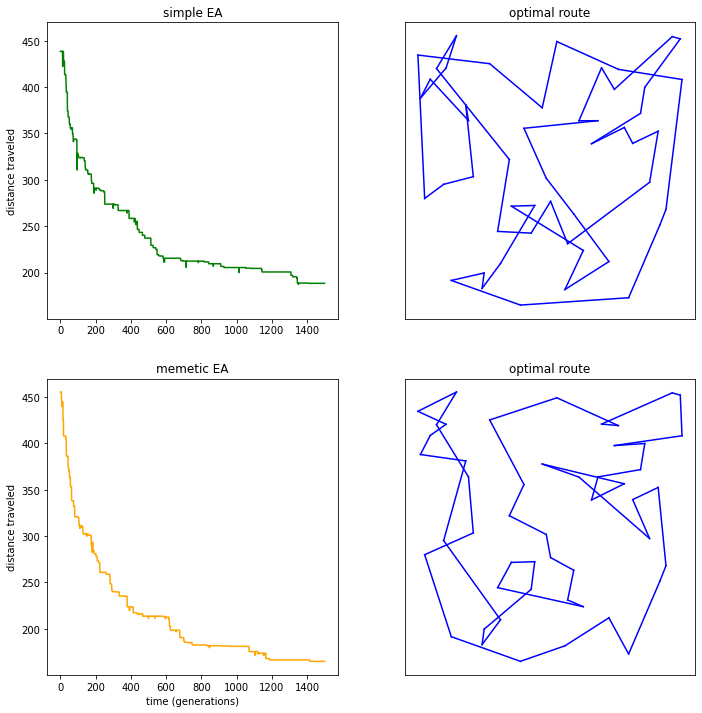

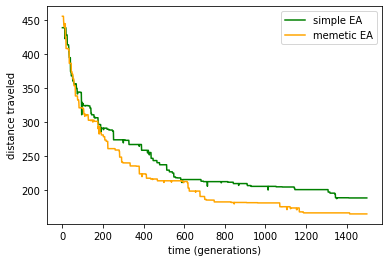

In [61]:

N = 50 # population size
num_generations = 1500 # number of generation to run the evolution algorithm
tournament_size = 2 # pool size for the tournament selection

pc = 0.1 # crossover probability
u = 0.01 # mutation rate

number_of_runs = 10 # number of times to run the EA algorithm

run_ea_and_plot_results(tsp_map, number_of_runs, N, num_generations, tournament_size, pc, u)

In [62]:
berlin_map = TSPmap()

# read the file-tsp and serialize into the TSP map and City classes
with open('berlin52.tsp') as f:
    for _ in range(6):
        f.readline()
    for line in f:
        line = line.strip()
        elems = line.split(' ')
        if len(elems) < 3:
            break
        
        x = float(elems[1])
        y = float(elems[2].strip())
        name = int(elems[0])
        tsp_map.cities[name] = City(x, y, str(name))

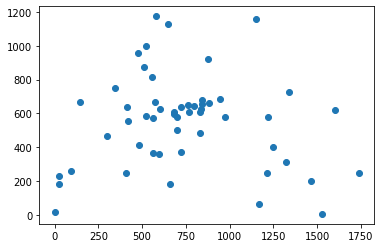

In [63]:
berlin_map.plot_map()

starting the simple EA
run 0 duration: 25.589770555496216  seconds
run 1 duration: 26.959738731384277  seconds
run 2 duration: 26.600435733795166  seconds
run 3 duration: 26.465010166168213  seconds
run 4 duration: 27.149162769317627  seconds
run 5 duration: 25.160686016082764  seconds
run 6 duration: 26.286871671676636  seconds
run 7 duration: 25.81925082206726  seconds
run 8 duration: 27.09021496772766  seconds
run 9 duration: 26.311105012893677  seconds
starting the memetic EA
run 0 duration: 41.04357624053955  seconds
run 1 duration: 40.54569435119629  seconds
run 2 duration: 35.974632263183594  seconds
run 3 duration: 31.916210889816284  seconds
run 4 duration: 33.39441776275635  seconds
run 5 duration: 37.85874032974243  seconds
run 6 duration: 38.61890196800232  seconds
run 7 duration: 38.80851721763611  seconds
run 8 duration: 37.55795168876648  seconds
run 9 duration: 41.216487407684326  seconds


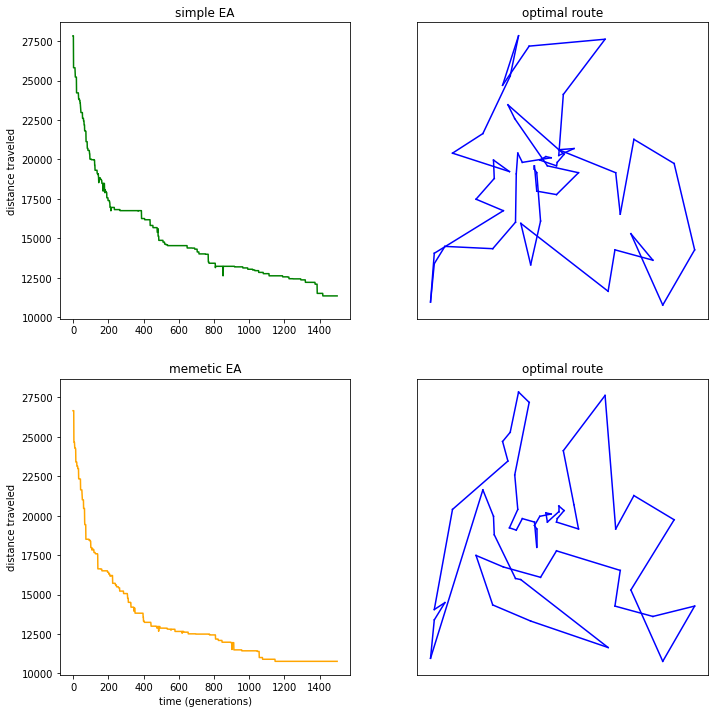

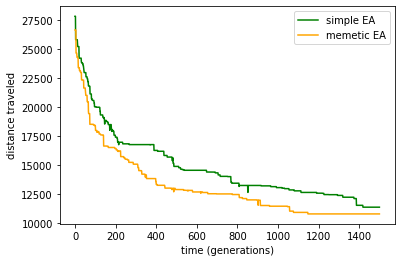

In [65]:
run_ea_and_plot_results(berlin_map, number_of_runs, N, num_generations, tournament_size, pc, u)


1. Compare your MA to the simple EA from the lectures by running both algorithms for for 1500 generations.
Please repeat each experiment 10 times to account for stochasticity, and perform this comparison for both
datasets, asking: does addition of local search improve performance?


In the code cells above this exact experiment setup is ran with the two sets of figures as result. The first set of figures is created with the 'file-tsp.txt' as input, the second set from a file called 'berlin52.tsp'. This last file was selected from the benchmarks available at 'http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/' and represents 52 hotspots in the city of Berlin, Germany. Each set of figures consists of two components: a composed figure of 4 subplots and a figure combining the results of the first figure. 

We define the labels for the figures as follows: "Figure \[filename\] \[figure number\]' (possible \[subfigure letter\])". Using this convention Figure file1c would refer to the composed figure of the first TSP map, subfigure c (which is the third one encountered from left to right). Figure berlin2 refers to the figure of the berlin map which displays both the orange and green line. Now that the figure reference system is (hopefully) clear, we can move on.

For both dataset the algorithms where executed with the same paramers, which can be found a few cells up. Most parameters where chosen sort of arbitrarily and copied from the TSP-EA simulation at 'https://computational-immunology.org/models/EA/examples/TSP-GA.html' except for N. Because of performance issues in the code setting N to 500 would result in the algorithms running for a substantial amount of time (an hour at least) without terminating. Therefore an N of 50 was choosen as this sped up the process and the size of the population would only change the rate at which possible better solutions would be found (bigger gene pool) but have no other effect on the comparison between the simple and memetic algorithm.

In Figure file2 and berlin2 we see a clear difference in the plotted lines between the simple and memetic algorithm, the memetic version reaches better solutions faster and also reaches an overall better solution after 1500 generations. From these graphs we can without a doubt conclude that local search does improve the performance of the EA.


2. Do you think the simple EA with the same number of generations is a fair baseline to answer this question?
Why/why not? If your answer is no, then please explain how you would perform an experiment with a fair
comparison.


By repeating each experiment 10 times and averaging the results we remove a lot of the 'noise' which can occur from the randomness present in the algorithm. In order to increase the quality of the comparison there are some further improvements possible:
- Innitiate both algorithms with the same random generated population at the start.
- Use the same seed for randomized operations in the algorithms so sampling and shuffling will have the same results (unless the local search has already swapped some connections).


3. In general, on the TSP problem, are memetic algorithms more effective than simple EAs? To answer this
question, please rely on (recent) results from the literature, and include references to the papers used.

No relevant (recent) papers where found which provided a fitting answer to this question.